In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import numpy as np
import torch
import torchvision
import tqdm
from torch import nn
from torchvision import transforms as T
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import random

In [3]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
from torchvision.datasets import CIFAR10

In [5]:
train_transform = T.Compose([
    T.RandomCrop((32, 32), padding=4),
    T.RandomHorizontalFlip(0.5),
    T.ColorJitter(contrast=0.25),
    T.ToTensor(),
    T.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),
])
val_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),
])

train_dataset = CIFAR10("./data/", download=True, train=True, transform=train_transform)
val_dataset = CIFAR10("./data/", download=True, train=False, transform=val_transform)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=100)

In [7]:
from src.utils import set_random_seed

In [8]:
from src.utils import train, predict

In [9]:
from src.layers.ttrl import TTRL

class TTRLModel(nn.Module):
    def __init__(self):
        super(TTRLModel, self).__init__()
        self.conv = nn.Sequential(
            nn.Sequential(
                nn.Conv2d(3, 64, (3, 3), padding="same"),
                nn.BatchNorm2d(64),
                nn.ReLU(),
            ),
            nn.Sequential(
                nn.Conv2d(64, 64, (3, 3), padding="same"),
                nn.BatchNorm2d(64),
                nn.ReLU(),
            ),
            nn.MaxPool2d((3, 3), stride=(2, 2), padding=(1, 1)),
            nn.Sequential(
                nn.Conv2d(64, 128, (3, 3), padding="same"),
                nn.BatchNorm2d(128),
                nn.ReLU(),
            ),
            nn.Sequential(
                nn.Conv2d(128, 128, (3, 3), padding="same"),
                nn.BatchNorm2d(128),
                nn.ReLU(),
            ),
            nn.MaxPool2d((3, 3), stride=(2, 2), padding=(1, 1)),
            nn.Sequential(
                nn.Conv2d(128, 128, (3, 3), padding="same"),
                nn.BatchNorm2d(128),
                nn.ReLU(),
            ),
            nn.Sequential(
                nn.Conv2d(128, 128, (3, 3), padding="same"),
                nn.BatchNorm2d(128),
                nn.ReLU(),
            )
        )
        self.ttrl = TTRL(((16, 8), (8,), (8,)), ((4, 32), (2,), (2,)), (10,), (10,))
    
    def forward(self, tensor):
        tensor = self.conv(tensor)
        tensor = torch.reshape(tensor, (tensor.shape[0], 16, 8, 8, 8))
        return self.ttrl(tensor)


set_random_seed(12345)
model = TTRLModel()

optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
criterion = nn.CrossEntropyLoss(reduction="mean")
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 30, gamma=0.1, verbose=True)
# scheduler = None
n_epochs = 100

device = "cuda:0" if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)
# device = "cpu"

Adjusting learning rate of group 0 to 1.0000e-02.


In [10]:
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(predicted_labels.to("cpu"), true_labels.to("cpu"))
print("tests passed")

tests passed


In [11]:
accuracies = train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler, plot=False)

  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 0, Train loss: 1.4238840973377227, Validation loss: 1.1703147888183594, Validation accuracy: 0.584


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 1, Train loss: 0.9454781670570374, Validation loss: 1.0300261974334717, Validation accuracy: 0.6622


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 2, Train loss: 0.7585296831727028, Validation loss: 0.7635011076927185, Validation accuracy: 0.7377


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 3, Train loss: 0.6535829743742942, Validation loss: 0.6413604617118835, Validation accuracy: 0.7832


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 4, Train loss: 0.5852715033888817, Validation loss: 0.6698040962219238, Validation accuracy: 0.7816


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 5, Train loss: 0.532384717643261, Validation loss: 0.7107222676277161, Validation accuracy: 0.7654


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 6, Train loss: 0.49211048555374143, Validation loss: 0.7031769752502441, Validation accuracy: 0.7766


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 7, Train loss: 0.4561392263770103, Validation loss: 0.5970245599746704, Validation accuracy: 0.8102


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 8, Train loss: 0.42306759643554687, Validation loss: 0.4948652684688568, Validation accuracy: 0.8344


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 9, Train loss: 0.3979766981601715, Validation loss: 0.5612380504608154, Validation accuracy: 0.8261


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 10, Train loss: 0.3732915794849396, Validation loss: 0.4543174207210541, Validation accuracy: 0.8472


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 11, Train loss: 0.35343651178479196, Validation loss: 0.5348303318023682, Validation accuracy: 0.8372


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 12, Train loss: 0.33360142105817797, Validation loss: 0.5181978940963745, Validation accuracy: 0.8451


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 13, Train loss: 0.3166382696032524, Validation loss: 0.4519746005535126, Validation accuracy: 0.8589


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 14, Train loss: 0.30098723390698434, Validation loss: 0.462340772151947, Validation accuracy: 0.8542


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 15, Train loss: 0.28565084809064867, Validation loss: 0.48752185702323914, Validation accuracy: 0.8467


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 16, Train loss: 0.2733261621892452, Validation loss: 0.4378930926322937, Validation accuracy: 0.8657


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 17, Train loss: 0.2587981895208359, Validation loss: 0.43800926208496094, Validation accuracy: 0.8668


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 18, Train loss: 0.24442480318248272, Validation loss: 0.506282389163971, Validation accuracy: 0.85


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 19, Train loss: 0.23697833944857122, Validation loss: 0.4338681399822235, Validation accuracy: 0.8761


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 20, Train loss: 0.22317865593731404, Validation loss: 0.4475286602973938, Validation accuracy: 0.8757


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 21, Train loss: 0.2122571557611227, Validation loss: 0.4601670801639557, Validation accuracy: 0.869


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 22, Train loss: 0.20608368603885174, Validation loss: 0.43863627314567566, Validation accuracy: 0.8769


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 23, Train loss: 0.1990299465060234, Validation loss: 0.49711689352989197, Validation accuracy: 0.8669


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 24, Train loss: 0.1926790047734976, Validation loss: 0.4735069274902344, Validation accuracy: 0.8761


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 25, Train loss: 0.17856912393867969, Validation loss: 0.39949414134025574, Validation accuracy: 0.8846


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 26, Train loss: 0.17415279151499272, Validation loss: 0.4781058132648468, Validation accuracy: 0.8695


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 27, Train loss: 0.1689727224111557, Validation loss: 0.4750942885875702, Validation accuracy: 0.8742


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 28, Train loss: 0.1614728833734989, Validation loss: 0.4496525824069977, Validation accuracy: 0.8802


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 29, Train loss: 0.1551067616865039, Validation loss: 0.47845378518104553, Validation accuracy: 0.881


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 30, Train loss: 0.09477695361152291, Validation loss: 0.4102506637573242, Validation accuracy: 0.903


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 31, Train loss: 0.07748419073969126, Validation loss: 0.422273188829422, Validation accuracy: 0.9032


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 32, Train loss: 0.07154228115081787, Validation loss: 0.44209232926368713, Validation accuracy: 0.9043


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 33, Train loss: 0.06465062263887375, Validation loss: 0.46126049757003784, Validation accuracy: 0.9043


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 34, Train loss: 0.060222486710175875, Validation loss: 0.4686887562274933, Validation accuracy: 0.9052


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 35, Train loss: 0.05980339978728443, Validation loss: 0.47376009821891785, Validation accuracy: 0.9043


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 36, Train loss: 0.056631593873724344, Validation loss: 0.4930140972137451, Validation accuracy: 0.9038


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 37, Train loss: 0.053398223826661706, Validation loss: 0.4959356188774109, Validation accuracy: 0.9038


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 38, Train loss: 0.05435179619397968, Validation loss: 0.49159568548202515, Validation accuracy: 0.9049


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 39, Train loss: 0.05044870261289179, Validation loss: 0.5164755582809448, Validation accuracy: 0.9045


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 40, Train loss: 0.04996029904158786, Validation loss: 0.5141036510467529, Validation accuracy: 0.9033


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 41, Train loss: 0.04818193959631026, Validation loss: 0.5358842611312866, Validation accuracy: 0.903


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 42, Train loss: 0.045291648895479736, Validation loss: 0.5413445234298706, Validation accuracy: 0.9052


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 43, Train loss: 0.04481549255130812, Validation loss: 0.5468232035636902, Validation accuracy: 0.9045


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 44, Train loss: 0.045397885452257467, Validation loss: 0.5487731099128723, Validation accuracy: 0.9045


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 45, Train loss: 0.04294721105135977, Validation loss: 0.554105818271637, Validation accuracy: 0.9047


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 46, Train loss: 0.040205457981675866, Validation loss: 0.5643545985221863, Validation accuracy: 0.9031


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 47, Train loss: 0.03962056851107627, Validation loss: 0.5791128873825073, Validation accuracy: 0.9046


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 48, Train loss: 0.039836549264146016, Validation loss: 0.5858365893363953, Validation accuracy: 0.9044


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 49, Train loss: 0.039474197725299746, Validation loss: 0.5738788843154907, Validation accuracy: 0.9059


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 50, Train loss: 0.03910665297089145, Validation loss: 0.5762832164764404, Validation accuracy: 0.9063


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 51, Train loss: 0.036741845153737816, Validation loss: 0.5991896986961365, Validation accuracy: 0.9042


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 52, Train loss: 0.03563722718693316, Validation loss: 0.6036418676376343, Validation accuracy: 0.9052


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 53, Train loss: 0.03438666699989699, Validation loss: 0.6156388521194458, Validation accuracy: 0.9059


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 54, Train loss: 0.03295317185064778, Validation loss: 0.6345226764678955, Validation accuracy: 0.9031


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 55, Train loss: 0.034000789943384006, Validation loss: 0.6096792221069336, Validation accuracy: 0.904


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 56, Train loss: 0.033473560369806366, Validation loss: 0.6247220039367676, Validation accuracy: 0.9065


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 57, Train loss: 0.03332494794367812, Validation loss: 0.6308181285858154, Validation accuracy: 0.9044


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 58, Train loss: 0.030509498970815913, Validation loss: 0.630062997341156, Validation accuracy: 0.9048


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 59, Train loss: 0.03328139931242913, Validation loss: 0.6442214846611023, Validation accuracy: 0.9032


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 60, Train loss: 0.028435782397165894, Validation loss: 0.632826566696167, Validation accuracy: 0.9052


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 61, Train loss: 0.026286331678042188, Validation loss: 0.6310597062110901, Validation accuracy: 0.9053


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 62, Train loss: 0.02593507648422383, Validation loss: 0.6364454030990601, Validation accuracy: 0.9055


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 63, Train loss: 0.02493275946995709, Validation loss: 0.6387001872062683, Validation accuracy: 0.9051


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 64, Train loss: 0.02541474864259362, Validation loss: 0.6370814442634583, Validation accuracy: 0.9059


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 65, Train loss: 0.024241155919269657, Validation loss: 0.6372119188308716, Validation accuracy: 0.9073


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 66, Train loss: 0.023928616845048965, Validation loss: 0.6378197073936462, Validation accuracy: 0.907


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 67, Train loss: 0.023442175270291046, Validation loss: 0.6386655569076538, Validation accuracy: 0.9063


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 68, Train loss: 0.02520079296687618, Validation loss: 0.6399017572402954, Validation accuracy: 0.9057


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 69, Train loss: 0.02278282099077478, Validation loss: 0.6397638320922852, Validation accuracy: 0.9062


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 70, Train loss: 0.023395199397811667, Validation loss: 0.6405441761016846, Validation accuracy: 0.9056


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 71, Train loss: 0.02278333312284667, Validation loss: 0.6485671997070312, Validation accuracy: 0.9068


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 72, Train loss: 0.023143850188935177, Validation loss: 0.651036262512207, Validation accuracy: 0.906


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 73, Train loss: 0.023129340486368163, Validation loss: 0.6468169689178467, Validation accuracy: 0.9062


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 74, Train loss: 0.02236899374227505, Validation loss: 0.6552103161811829, Validation accuracy: 0.906


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 75, Train loss: 0.023291183460853064, Validation loss: 0.6463198065757751, Validation accuracy: 0.9055


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 76, Train loss: 0.023483867338625713, Validation loss: 0.6490254998207092, Validation accuracy: 0.9054


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 77, Train loss: 0.02367580241127871, Validation loss: 0.6536518931388855, Validation accuracy: 0.9057


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 78, Train loss: 0.022985252380836756, Validation loss: 0.6586374640464783, Validation accuracy: 0.9054


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 79, Train loss: 0.021487424666353037, Validation loss: 0.6555417776107788, Validation accuracy: 0.9059


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 80, Train loss: 0.02337503834825475, Validation loss: 0.6561858654022217, Validation accuracy: 0.905


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 81, Train loss: 0.022543175544065888, Validation loss: 0.6587910652160645, Validation accuracy: 0.9046


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 82, Train loss: 0.0222923045293428, Validation loss: 0.6676844954490662, Validation accuracy: 0.9053


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 83, Train loss: 0.022181545772298705, Validation loss: 0.6613258123397827, Validation accuracy: 0.9055


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 84, Train loss: 0.022611925136181526, Validation loss: 0.6593432426452637, Validation accuracy: 0.9053


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 85, Train loss: 0.022379725073231386, Validation loss: 0.6650442481040955, Validation accuracy: 0.905


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 86, Train loss: 0.02222057729808148, Validation loss: 0.6724352240562439, Validation accuracy: 0.9046


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 87, Train loss: 0.02208232129085809, Validation loss: 0.6743796467781067, Validation accuracy: 0.9056


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 88, Train loss: 0.02192217600974254, Validation loss: 0.667518675327301, Validation accuracy: 0.9067


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.
Epoch: 89, Train loss: 0.021185535262571647, Validation loss: 0.6726310849189758, Validation accuracy: 0.9055


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.
Epoch: 90, Train loss: 0.021752224275143818, Validation loss: 0.668530285358429, Validation accuracy: 0.9055


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.
Epoch: 91, Train loss: 0.02231341216014698, Validation loss: 0.6674826145172119, Validation accuracy: 0.9053


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.
Epoch: 92, Train loss: 0.020482843446312474, Validation loss: 0.6617458462715149, Validation accuracy: 0.9063


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.
Epoch: 93, Train loss: 0.020395805410575122, Validation loss: 0.6661627292633057, Validation accuracy: 0.9065


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.
Epoch: 94, Train loss: 0.020660182164167054, Validation loss: 0.6690459251403809, Validation accuracy: 0.9067


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.
Epoch: 95, Train loss: 0.020110188598860986, Validation loss: 0.6682015061378479, Validation accuracy: 0.9047


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.
Epoch: 96, Train loss: 0.021292042051441966, Validation loss: 0.6703956723213196, Validation accuracy: 0.9051


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.
Epoch: 97, Train loss: 0.022084706990106496, Validation loss: 0.6713377833366394, Validation accuracy: 0.9059


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.
Epoch: 98, Train loss: 0.020714989422645887, Validation loss: 0.6647072434425354, Validation accuracy: 0.9055


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.
Epoch: 99, Train loss: 0.020108540646819165, Validation loss: 0.6703460812568665, Validation accuracy: 0.9061


Accuracy: 0.9061


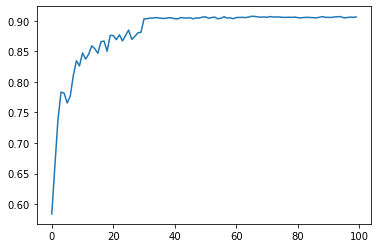

In [13]:
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(true_labels.to("cpu"), predicted_labels.to("cpu"))
print(f"Accuracy: {accuracy}")
plt.plot(accuracies)
plt.show()

In [14]:
torch.save({
    "model": model.state_dict(),
}, "./models/conv-trl-8-state-dict.pt")

In [10]:
# checkpoint = torch.load("./models/conv-trl-3-state-dict.pt")
# model.load_state_dict(checkpoint["model"])

<All keys matched successfully>